In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

# Reading csv and converted values in status column : acquired = 1 and else = 0
df = pd.read_csv('data.csv', converters={
                 'status': lambda x: int(x == 'acquired')})
df.head(n=10)


,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,1
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,1
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,1
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,1
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,0
5,379,CA,37.406914,-122.090370,94043,c:22898,Mountain View,Mountain View CA 94043,Matisse Networks,0,...,c:22898,0,0,0,1,0,0,3.0000,1,0
6,195,CA,37.391559,-122.070264,94041,c:16191,Mountain View,NaN,RingCube Technologies,1,...,c:16191,1,0,1,1,0,0,1.6667,1,1
7,875,CA,38.057107,-122.513742,94901,c:5192,San Rafael,NaN,ClairMail,1,...,c:5192,0,0,1,1,0,1,3.5000,1,1
8,16,MA,42.712207,-73.203599,1267,c:1043,Williamstown,Williamstown MA 1267,VoodooVox,1,...,c:1043,1,0,1,0,0,1,4.0000,1,1
9,846,CA,37.427235,-122.145783,94306,c:498,Palo Alto,NaN,Doostang,1,...,c:498,1,1,1,0,0,0,1.0000,1,1


In [144]:
# how many null values are present
null=pd.DataFrame(df.isnull().sum(),columns=["Null Values"])
null["% Missing Values"]=(df.isna().sum()/len(df)*100)
null = null[null["% Missing Values"] > 0]
null.style.background_gradient(cmap='viridis',low =0.2,high=0.1) 

,Null Values,% Missing Values
Unnamed: 6,493,53.412784
closed_at,588,63.705309
age_first_milestone_year,152,16.468039
age_last_milestone_year,152,16.468039
state_code.1,1,0.108342


In [145]:
df['closed_at'] = df['closed_at'].fillna(value="31/12/2013")

In [146]:
# checked negative  values
age=["age_first_funding_year","age_last_funding_year","age_first_milestone_year","age_last_milestone_year"]

for a in range(len(age)):
    print("Negative value in '{}' column  : {} ".format(age[a],(df[age[a]]<0).any()))


Negative value in 'age_first_funding_year' column  : True 
Negative value in 'age_last_funding_year' column  : True 
Negative value in 'age_first_milestone_year' column  : True 
Negative value in 'age_last_milestone_year' column  : True 


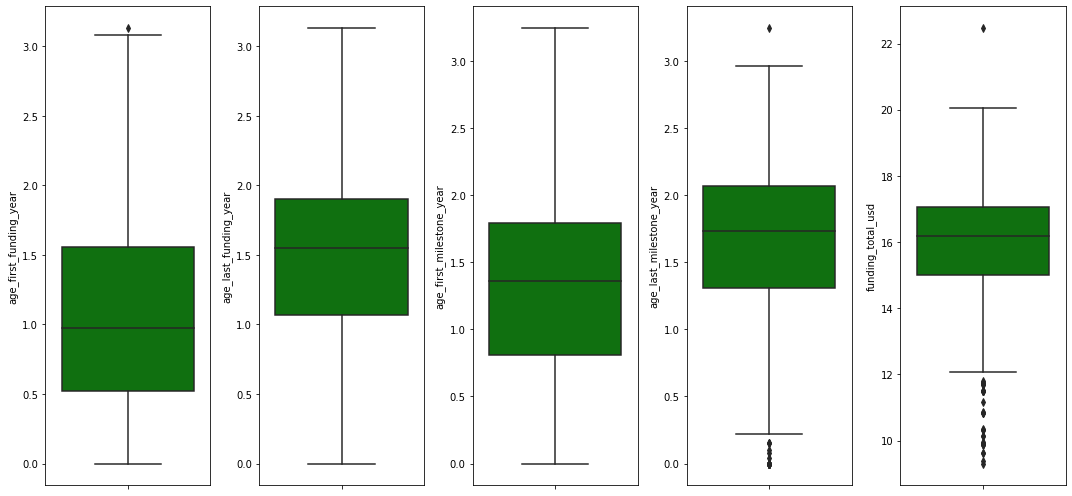

In [147]:
# dropped negative values
df=df.drop(df[df.age_first_funding_year<0].index)
df=df.drop(df[df.age_last_funding_year<0].index)
df=df.drop(df[df.age_first_milestone_year<0].index)
df=df.drop(df[df.age_last_milestone_year<0].index)

df["age_first_funding_year"] = np.log1p(df["age_first_funding_year"])
df["age_last_funding_year"] = np.log1p(df["age_last_funding_year"])
df["age_first_milestone_year"] = np.log1p(df["age_first_milestone_year"])
df["age_last_milestone_year"] = np.log1p(df["age_last_milestone_year"])
df["funding_total_usd"] = np.log1p(df["funding_total_usd"])


# checking for outliers
featuresNumfinal = ['age_first_funding_year','age_last_funding_year','age_first_milestone_year','age_last_milestone_year','funding_total_usd']

plt.figure(figsize=(15, 7))
for i in range(0, len(featuresNumfinal)):
    plt.subplot(1, len(featuresNumfinal), i+1)
    sns.boxplot(y=df[featuresNumfinal[i]], color='green', orient='v')
    plt.tight_layout()


In [148]:
# combined round columns into one
df['has_RoundABCD'] = np.where((df['has_roundA'] == 1) | (df['has_roundB'] == 1) | (df['has_roundC'] == 1) | (df['has_roundD'] == 1), 1, 0)

# combined vc and angel columns into one
df['has_Investor'] = np.where((df['has_VC'] == 1) | (df['has_angel'] == 1), 1, 0)

# combined new columns into one
df['has_Seed'] = np.where((df['has_RoundABCD'] == 0) & (df['has_Investor'] == 1), 1, 0)

# created to combine startups with no funding rounds, vc and angel
df['invalid_startup'] = np.where((df['has_RoundABCD'] == 0) & (df['has_VC'] == 0) & (df['has_angel'] == 0), 1, 0)

# column to get age of startup
df.founded_at=pd.to_datetime(df.founded_at)
df.closed_at=pd.to_datetime(df.closed_at)
df['age_closed_startup'] = df.apply(lambda row: (row.closed_at - row.founded_at) , axis=1)

df['age_startup_year'] = df['age_closed_startup'].dt.days /365
print(df['age_startup_year'].head)


<bound method NDFrame.head of 0       7.002740
1      14.008219
2       4.791781
3      12.005479
4       2.169863
         ...    
918     5.000000
919    10.487671
920    13.468493
921     5.000000
922    11.005479
Name: age_startup_year, Length: 840, dtype: float64>


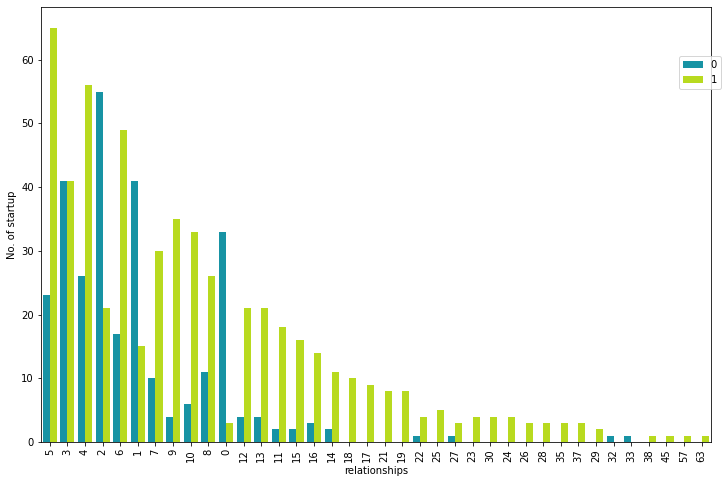

In [149]:
# plotted a distribution of relationships

fig, ax = plt.subplots(figsize=(12,8))

plot = sns.countplot(x="relationships", hue="status", data=df, palette="nipy_spectral",
              order=df.relationships.value_counts().index)

plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plot = ax.set(xlabel="relationships", ylabel="No. of startup")
plt.legend(bbox_to_anchor=(0.945, 0.90))

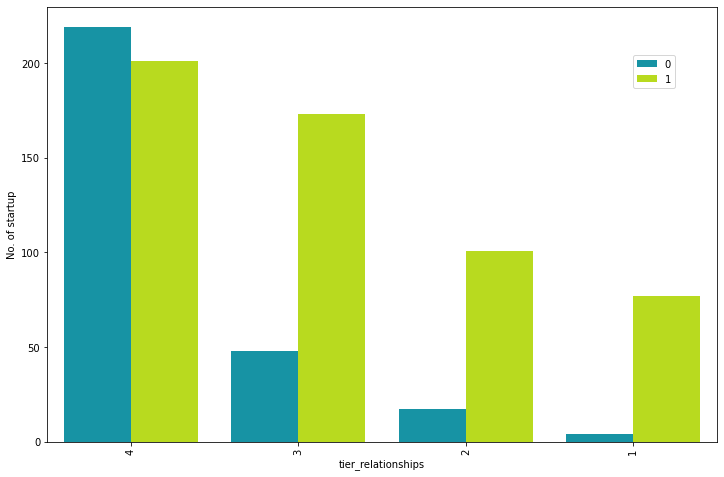

In [150]:
# created a list of our conditions
conditions = [
    (df['relationships'] <= 5),
    (df['relationships'] > 5) & (df['relationships'] <= 10),
    (df['relationships'] > 10) & (df['relationships'] <= 16),
    (df['relationships'] > 16)
    ]

# created a list of the values we want to assign for each condition
values = ['4', '3', '2', '1']

# created a new column and use np.select to assign values to it using our lists as arguments
df['tier_relationships'] = np.select(conditions, values)

fig, ax = plt.subplots(figsize=(12,8))

plot = sns.countplot(x="tier_relationships", hue="status", data=df, palette="nipy_spectral",
              order=df.tier_relationships.value_counts().index)

plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plot = ax.set(xlabel="tier_relationships", ylabel="No. of startup")
plt.legend(bbox_to_anchor=(0.945, 0.90))

In [151]:
df['tier_relationships'] = df.tier_relationships.astype(int)

# dropped columns
df = df.drop(['relationships','Unnamed: 0','Unnamed: 6', 'name', 'founded_at', 'closed_at', 'first_funding_at', 'last_funding_at', 'id', 'object_id', 'labels', 'latitude', 'longitude', 'zip_code', 'city', 'state_code','category_code', 'age_closed_startup', 'state_code.1'], axis=1)

# replaced NA/null values
df['age_first_milestone_year'] = df['age_first_milestone_year'].fillna(value=0)
df['age_last_milestone_year'] = df['age_last_milestone_year'].fillna(value=0)

In [152]:
# extracted feature columns and target column
features = df.loc[:, df.columns != 'status']
target = df.loc[:, 'status']

# split the dataset into test and train  train:test=80:20
X_train, X_test, y_train, y_test  = train_test_split(features, target, train_size=0.8, random_state=42)

# print confusion matrix and calculate accuracy rate
def print_performance(pred,actual):
    actual_array = np.array(actual)
    unique_label = np.unique([actual, pred])
    cf = pd.DataFrame(
        confusion_matrix(actual_array, pred, labels=unique_label), 
        index=['Actual:{:}'.format(x) for x in unique_label], 
        columns=['Pred:{:}'.format(x) for x in unique_label]
    )
    sns.heatmap(cf, annot = True, cmap = 'YlGnBu', fmt = '.8g')
    plt.show()
    print(cf)
    print('Percent Acquired correctly predicted: ', cf['Pred:1'][1]/(cf['Pred:0'][1] +cf['Pred:1'][1])*100)
    print('Percent Not Acquired correctly predicted: ', cf['Pred:0'][0]/(cf['Pred:0'][0] +cf['Pred:1'][0])*100)

(672, 36)


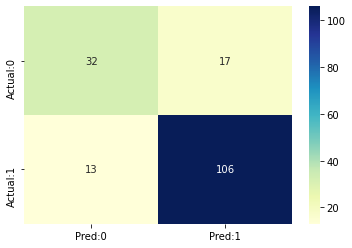

          Pred:0  Pred:1
Actual:0      32      17
Actual:1      13     106
Percent Acquired correctly predicted:  89.07563025210085
Percent Not Acquired correctly predicted:  65.3061224489796
Accuracy of the test set:  0.8214285714285714


In [153]:
# Logistic Regression
logistic_clf = LogisticRegression(solver='liblinear', penalty='l1')
logistic_clf.fit(X_train, y_train)
y_pred = logistic_clf.predict(X_test)
print_performance(y_pred, y_test)
print("Accuracy of the test set: ", accuracy_score(y_test, y_pred))

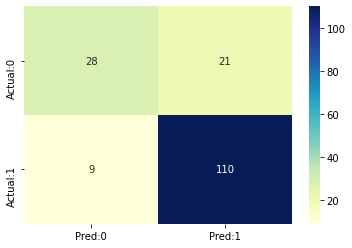

          Pred:0  Pred:1
Actual:0      28      21
Actual:1       9     110
Percent Acquired correctly predicted:  92.43697478991596
Percent Not Acquired correctly predicted:  57.14285714285714
Accuracy of the test set:  0.8214285714285714


In [154]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)
y_test_pred_knn = knn_clf.predict(X_test)
print_performance(y_test_pred_knn, y_test)
print("Accuracy of the test set: ", accuracy_score(y_test, y_test_pred_knn))

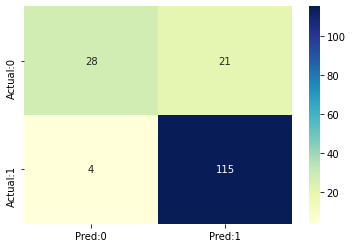

          Pred:0  Pred:1
Actual:0      28      21
Actual:1       4     115
Percent Acquired correctly predicted:  96.63865546218487
Percent Not Acquired correctly predicted:  57.14285714285714
Accuracy of the test set:  0.8511904761904762


In [155]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=22, max_depth=7, criterion="gini")
forest.fit(X_train, y_train)
y_test_pred_forest = forest.predict(X_test)
print_performance(y_test_pred_forest, y_test)
print("Accuracy of the test set: ", accuracy_score(y_test, y_test_pred_forest))  

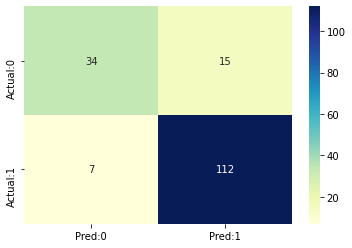

          Pred:0  Pred:1
Actual:0      34      15
Actual:1       7     112
Percent Acquired correctly predicted:  94.11764705882352
Percent Not Acquired correctly predicted:  69.38775510204081
Accuracy of the test set:  0.8690476190476191


In [156]:
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train, y_train)
y_pred_ada = ab.predict(X_test)
print_performance(y_pred_ada, y_test)
print("Accuracy of the test set: ", accuracy_score(y_test, y_pred_ada))

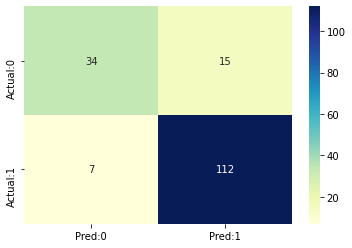

          Pred:0  Pred:1
Actual:0      34      15
Actual:1       7     112
Percent Acquired correctly predicted:  94.11764705882352
Percent Not Acquired correctly predicted:  69.38775510204081
Accuracy of the test set:  0.8690476190476191


In [157]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(learning_rate=0.02, max_depth=4, random_state=100, n_estimators=1000)
gbc.fit(X_train,y_train)
y_pred_gbc = ab.predict(X_test)
print_performance(y_pred_gbc, y_test)
print("Accuracy of the test set: ", accuracy_score(y_test, y_pred_gbc))